# Spatial Analysis with Python

There are people who need to do spatial (geographic) analysis, who don't know how to use proper GIS (Geographic Information System) software like ArcPro or QGIS, but do know Python. In many of those cases the point isn't to generate a map, but just to do calculations. Python is a viable solution, and is sometimes faster.

I'm going to cover two main applications, and show a few more handy details along the way:

- **Spatial Join** – trying to figure out which geographic regions points are located
- **Sampling Raster Data** – finding the value of grid/pixel-based geographic data at point locations

## Creating the GIS Python environment

I always use the [Anaconda Python Distribution](), which is just a version of the free and open source Python programming language, which is packaged with many other useful modules (or libraries that add extra functionality). I like it because by default it gets installed in your local user directory**, so you don't need administrative permissions, and if there any problems it's easy to just delete it and re-install since it's separate from all of your computer's system files.

Even though `conda`, which is the "package manager" that comes with Anaconda, checks and installs all dependencies (the other modules a module depends upon to run) when you install a module, I have run into situations where modules or their underlying libraries conflict with each other, so for GIS work I always create a separate "environment" in which to do this work. 

For these examples you need to run, in your Terminal on Mac or Linux, or in the Anaconda Prompt on Windows, this command to create the environment I've chosen to call `GIS`, and install the necessary modules. (The `-c conda-forge` part is just so conda will grab these from a certain repository.)

```
conda create --name GIS -c conda-forge geopandas rasterstats jupyterlab matplotlib descartes
```

Then, to "activate" this new environment, which just makes these isolated installs available for running, you type:

```
conda activate GIS`
```

and then to launch JupyterLab you type:

```
jupyter lab
```

---

## GeoPandas Spatial JOIN

**This is a simple example of finding which census tract a bunch of households sit within.** The census tracts are polygons stored in an ESRI Shapefile, and each household is located using pairs of latitude and longitude coordinates stored in a comma-separated value (CSV) text file. The spatial inclusion test will be done using the [GeoPandas](http://geopandas.org/) Python module.

[Pandas](https://pandas.pydata.org/) is the leading Python module for dealing with tabular data (spreadsheets with rows and columns). It keeps rows aligned properly and eliminates the need to iterate through rows to do common operations.

From the GeoPandas Documentation: 
"GeoPandas is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by Pandas to allow spatial operations on geometric types. Geometric operations are performed by [shapely](https://shapely.readthedocs.io/). Geopandas further depends on [fiona](https://fiona.readthedocs.io/) for file access and [descartes](https://pypi.python.org/pypi/descartes) and [matplotlib](http://matplotlib.org/) for plotting."

### Import modules

In [12]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

# This will only be used later for creating a directory if it doesn't exist
import os

# This module is only for the visualizations, which are optional
import matplotlib.pyplot as plt
%matplotlib inline

### Read in LA County census tracts shapefile

This is the 2010 California, Los Angeles County ESRI Shapefile, downloaded from [the US Census Bureau web interface](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Census+Tracts). 

Note that the `geometry` column is the special geographic data type column in this GeoDataFrame. It is a [shapely Geometric Object](https://shapely.readthedocs.io/en/latest/manual.html#geometric-objects), but it doesn't have to be named "geometry" – that's just the default.

In [3]:
tracts = gpd.read_file('data/LA_CensusTracts/CENSUS_TRACTS_2000.shp')

tracts.head()

,CT00,LABEL,Shape_STAr,Shape_STLe,geometry
0,101110,1011.10,1.228537e+07,15056.954289,"POLYGON ((6475581.002 1916939.627, 6475580.499..."
1,101120,1011.20,1.364394e+08,70339.952869,"POLYGON ((6471660.000 1919631.502, 6471661.499..."
2,101210,1012.10,7.019669e+06,12082.404482,"POLYGON ((6473070.498 1913983.375, 6472914.850..."
3,101220,1012.20,7.485860e+06,12652.916695,"POLYGON ((6477593.248 1914091.178, 6477595.001..."
4,101300,1013.00,2.784498e+07,28343.215220,"POLYGON ((6480645.620 1906746.726, 6480594.842..."


### Read in Zipped (.zip) shapefile

**If you know the file name and path within a zipped shapefile (set of files in a folder), you don't even have to unzip it before reading!**

Here is the same operation performed on the zipped Shapefile:

In [4]:
tracts = gpd.read_file('zip://data/LA_CensusTracts.zip!LA_CensusTracts/CENSUS_TRACTS_2000.shp')

tracts.head()

,CT00,LABEL,Shape_STAr,Shape_STLe,geometry
0,101110,1011.10,1.228537e+07,15056.954289,"POLYGON ((6475581.002 1916939.627, 6475580.499..."
1,101120,1011.20,1.364394e+08,70339.952869,"POLYGON ((6471660.000 1919631.502, 6471661.499..."
2,101210,1012.10,7.019669e+06,12082.404482,"POLYGON ((6473070.498 1913983.375, 6472914.850..."
3,101220,1012.20,7.485860e+06,12652.916695,"POLYGON ((6477593.248 1914091.178, 6477595.001..."
4,101300,1013.00,2.784498e+07,28343.215220,"POLYGON ((6480645.620 1906746.726, 6480594.842..."


### Each GeoDataFrame has a Coordinate Reference System (CRS)

The CRS defines the geographic coordinate system (projection). Unlike ArcGIS and ArcPro, spatial calculations in GeoPandas can't be done successfully across different CRSs – you'll need to convert before analyzing.

In [5]:
tracts.crs

{'proj': 'lcc',
 'lat_0': 33.5,
 'lon_0': -118,
 'lat_1': 34.0333333333333,
 'lat_2': 35.4666666666667,
 'x_0': 2000000,
 'y_0': 500000,
 'datum': 'NAD83',
 'units': 'us-ft',
 'no_defs': True}

### Simple visualization

I hardly ever use Python to do geographic visulalization because I think it's a real pain! It does come in handy sometimes, though, to be able to check that what you have is what you expect, and there are basic `plot()` methods built into GeoPandas.

- **matplotlib** is required for general plotting with points
- **descartes** package is required for plotting polygons (but doesn't need to be explicitly imported)

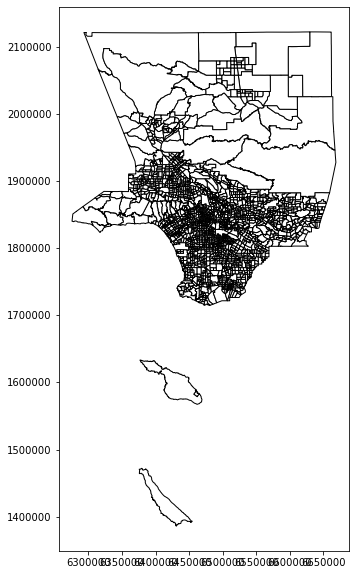

In [6]:
tracts.plot(color='white', edgecolor='black', figsize=(10,10));

## Read family household data (lat/lon) coordinates from CSV file

This is a very small, attribute-randomized subset (rows and columns) of household data from [InfoUSA](https://www.infousa.com/). *It will be useless for research use, but works well for this example.*

- Be sure to read 'familyid' as a string or initial zeroes will be lost!
- Only reading in some of the columns for this operation

In [7]:
data_cols = ['familyid','longitude','latitude']

eth = pd.read_csv('data/la_family_data.csv', sep=',', usecols=data_cols, dtype={'familyid': 'str'})

print(eth.shape)
eth.head()

(10000, 3)


,familyid,latitude,longitude
0,000106617324,34.13613,-118.14349
1,000106679098,33.84097,-118.06158
2,000106273271,34.69933,-118.13906
3,000106308511,33.79798,-118.11764
4,000106431883,34.40821,-118.44098


### Lat/Lon pairs need to be converted to a Point() data type

The latitude, longitude pairs need to be put together into geographic shapely `Point()` data objects.

First, we'll create a new column in which we'll store tuples of (lat, lon) from each of the individual columns using the build-in Python `zip()` function. *(Note that zip() creates a "generator", which generates the output results on demand, and `list()` expands those results into a list of tuples. I know that part might be confusing...)*

In [24]:
eth['coordinates'] = list(zip(eth['longitude'], eth['latitude']))
eth.head()

,familyid,latitude,longitude,coordinates
0,000106617324,34.13613,-118.14349,"(-118.14348999999999, 34.13613)"
1,000106679098,33.84097,-118.06158,"(-118.06158, 33.84097)"
2,000106273271,34.69933,-118.13906,"(-118.13906000000001, 34.699329999999996)"
3,000106308511,33.79798,-118.11764,"(-118.11764, 33.797979999999995)"
4,000106431883,34.40821,-118.44098,"(-118.44098000000001, 34.40821)"


#### Create the Point()s without explicitly iterating over rows

We will apply the `Point` function to all rows, and assign the reasult to the same `coordinates` column.

**Note that at this point this is still a Pandas DataFrame!**

In [34]:
eth['coordinates'] = eth['coordinates'].apply(Point)
eth.head()

,familyid,latitude,longitude,coordinates
0,000106617324,34.13613,-118.14349,POINT (-118.14349 34.13613)
1,000106679098,33.84097,-118.06158,POINT (-118.06158 33.84097)
2,000106273271,34.69933,-118.13906,POINT (-118.13906 34.69933)
3,000106308511,33.79798,-118.11764,POINT (-118.11764 33.79798)
4,000106431883,34.40821,-118.44098,POINT (-118.44098 34.40821)


### Convert to a GeoDataFrame, specifying which column contains the geometry

Here is where you can see that the `geometry` object column doesn't need to be called "geometry"

### Set and change the CRS so it's the same as the census tracts

- Have to set the Coordinate Reference System (CRS) initialy to say it's been hand-coded lat/lon, `epsg:4326`
- Then reproject to same CRS as tracts

**Note: If you have many more household points than points in your census tract geometries, it can be faster to reproject the census tract polygons instead of the household points. In the case of the whole US, this crossover point happened at around 400,000 points.**

In [43]:
gdf = gpd.GeoDataFrame(eth, geometry='coordinates', crs='epsg:4326')
gdf.head()

,familyid,latitude,longitude,coordinates
0,000106617324,34.13613,-118.14349,POINT (-118.14349 34.13613)
1,000106679098,33.84097,-118.06158,POINT (-118.06158 33.84097)
2,000106273271,34.69933,-118.13906,POINT (-118.13906 34.69933)
3,000106308511,33.79798,-118.11764,POINT (-118.11764 33.79798)
4,000106431883,34.40821,-118.44098,POINT (-118.44098 34.40821)


In [44]:
gdf = gdf.to_crs(crs=tracts.crs)
gdf.head()

,familyid,latitude,longitude,coordinates
0,000106617324,34.13613,-118.14349,POINT (6518245.392 1871953.469)
1,000106679098,33.84097,-118.06158,POINT (6542966.232 1764513.216)
2,000106273271,34.69933,-118.13906,POINT (6519869.499 2076912.222)
3,000106308511,33.79798,-118.11764,POINT (6525923.791 1748883.201)
4,000106431883,34.40821,-118.44098,POINT (6428657.202 1971229.228)


### Plot a random sample of the points in our new GeoDataFrame

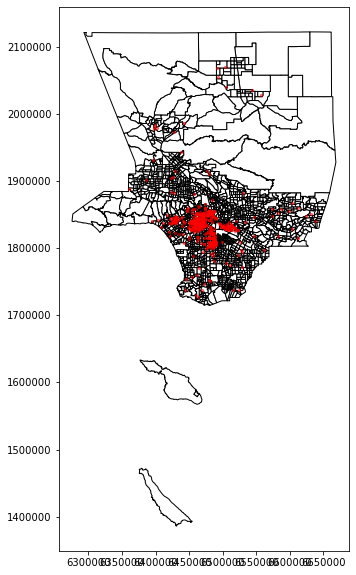

In [10]:
ax = tracts.plot(color='white', edgecolor='black', figsize=(10,10));

# We can now plot the points in our GeoDataFrame
gdf['coordinates'].sample(n=500).plot(ax=ax, markersize=5, alpha=0.5, color='red');

## Do the spatial JOIN

**This is where we get the census tract ID joined to our family data points.**

- We'll do a "left" join so we don't lose any points if some of our families don't happen to fall within a census tract – we'll just get a NULL (None) in the CT100 field.
- 'within' just slightly faster operation than 'intersects' or 'contains' – For points in a polygon it shouldn't matter which operation you use

In [11]:
eth_tracts = gpd.sjoin(gdf, tracts, how="left", op='within')

eth_tracts[['familyid','CT00']].head()

,familyid,CT00
0,000106617324,463600
1,000106679098,555103
2,000106273271,900806
3,000106308511,574300
4,000106431883,920043


### Saving only the two fields that we need to output CSV

In [12]:
eth_tracts[['familyid','CT00']].to_csv('la_family_tracts.csv', index=False, encoding='utf-8')

### Alternatively save data to shapefile for easier mapping

I like to put shapefiles in their own directory since a "shapefile" really consists of multiple files, and this makes it easier to keep them together.

- *Creating the directory will give an error if it already exists, so I check whether it's already been created first.*
- *This also happens to be an easy way to create a DBF file of your data!*

In [13]:
if not os.path.exists('data/la_family_SHP'):
	os.mkdir('data/la_family_SHP')
    
eth_tracts[['familyid', 'coordinates', 'CT00']].to_file('data/la_family_SHP/la_family_points.shp')

---

## Large data timing on Spatial JOIN

We ran the same spatial join on the DVS Lab machines using both GeoPandas and ArcPro for various numbers of family household coordinates [100k, 200k, 1M, 2M] and measured the time it took to complete the three different tasks:

- Converting (lat,lon) pairs into Points()
- Reprojecting the CRS (which isn't really necessary with ArcPro)
- Doing the spatial join

**GeoPandas was 2-8 times faster!** *shorter time = lower point on graph)*

<img src='images/GeoPandasArcProComparison.png' width=800>

---

# Sample raster values at shapefile points

**In this example, we want to see what measured polution levels are at the centers of census block groups.**

- Polution data is "raster data", or pixels in a grid that are tied to a geographic coordinate system. We can read this with the [rasterio](https://rasterio.readthedocs.io/en/latest/) module.
- Census block group centroids were downloaded in shapefile. We'll use GeoPandas for this again.
- Sampling of the raster data at the points will be done using the [rasterstats](https://pythonhosted.org/rasterstats/) module.

In [1]:
from rasterstats import zonal_stats, point_query
import rasterio
from rasterio.plot import show, show_hist
from shapely.geometry import Point

## Raster data

The raster data is North American Regional Estimates of ground-level fine particulate matter (PM<sub>2.5</sub>) downloaded in either ASCII or NetCDF format from the [Atmospheric Composition Analysis Group](http://fizz.phys.dal.ca/~atmos/martin/?page_id=140#V4.NA.02) at Dalhousie University. 

## Raster data: Reading zipped ASCII file

https://rasterio.readthedocs.io/en/stable/topics/datasets.html

In [2]:
pm25 = rasterio.open('zip://data/GWRwSPEC_PM25_NA_200001_200012-RH35-NoNegs.asc.zip!/GWRwSPEC_PM25_NA_200001_200012-RH35-NoNegs.asc')
pm25.meta

{'driver': 'AAIGrid',
 'dtype': 'float32',
 'nodata': -999.9000244140625,
 'width': 9300,
 'height': 4550,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.01, 0.0, -138.0,
        0.0, -0.01, 68.0)}

## Reading NetCDF file

In [3]:
pm25_nc = rasterio.open('data/GWRwSPEC_PM25_NA_200001_200012-RH35.nc')
pm25_nc.meta

{'driver': 'netCDF',
 'dtype': 'float32',
 'nodata': 9.969209968386869e+36,
 'width': 9300,
 'height': 4550,
 'count': 1,
 'crs': None,
 'transform': Affine(0.009999999360046485, 0.0, -137.99999511686752,
        0.0, -0.010000000788264548, 68.00000274697616)}

In [4]:
pm25.crs

CRS.from_epsg(4326)

## Viewing raster data

To get a quick look at the raster data, we can use the `show()` function built into `rasterio.plot`, which seems to be based on the matplotlib `imshow()` function.

Since the data uses -999 for null values, we need to set the minimum value for the colormap explicitly with the `vmin=` argument. (`vmax=` isn't necessary, but I'm using it here to boost the low levels a bit, artificially.)

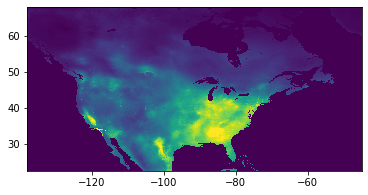

In [10]:
show((pm25,1), transform=pm25.transform, vmin=1, vmax=16, cmap='viridis')

## Point data: Reading a shapefile into a GeoDataFrame

Takes just slightly longer reading from a zipped shapefile than non.

In [13]:
# blkgrps = gpd.read_file('data/popctr_blkgrp2010/popctr_blkgrp2010.shp')

blkgrps = gpd.read_file('zip://data/popctr_blkgrp2010.zip')

In [15]:
blkgrps.shape

(220334, 9)

In [16]:
blkgrps.head()

,FIPS,STATE,COUNTY,TRACT,BLKGRP,POPULATION,LATITUDE,LONGITUDE,geometry
0,010010201001,01,001,020100,1,698,32.464812,-86.486527,POINT (-86.48653 32.46481)
1,010010201002,01,001,020100,2,1214,32.482391,-86.486912,POINT (-86.48691 32.48239)
2,010010202001,01,001,020200,1,1003,32.478035,-86.474786,POINT (-86.47479 32.47803)
3,010010202002,01,001,020200,2,1167,32.466372,-86.471060,POINT (-86.47106 32.46637)
4,010010203001,01,001,020300,1,2549,32.476828,-86.460326,POINT (-86.46033 32.47683)


#### CRS (coordinate reference system)

- epsg:4326 - WGS84 (World Geodetic System 1984) – lat/lon (hand-coded)
- epsg:4269 - NAD83 (North American Datum 1983)

In [17]:
blkgrps.crs

{'init': 'epsg:4269'}

### Viewing a sample of the block group points

GeoPandas has a couple of data sets built in. One of them is a low resolution version of the world country outlines from Natural Earth.

In [18]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

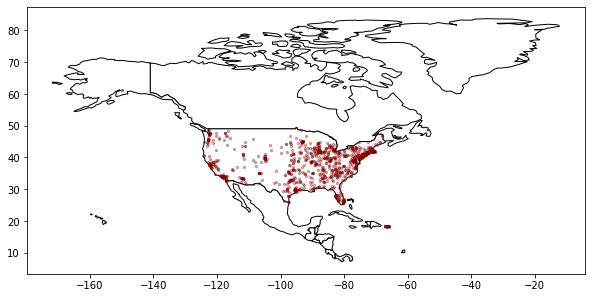

In [19]:
# We restrict background polygons to North America
ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', figsize=(10,10))

# We can now plot the points in our GeoDataFrame
blkgrps['geometry'].sample(n=1000).plot(ax=ax, markersize=5, alpha=0.33, color='darkred');

## Point query

**Note that with rasterstats point_query you don't have to reproject the data into the same CRS!**

### Read the raster data

The raster data isn't actually read into memory until you explicitly request it, and then you also have to specify the "channel" you want. In this case we only have one. Reading raster data into Numpy ndarray takes a few seconds the first time through

In [21]:
raster_data = pm25.read(1)

### Test on subset of points

As a test we'll only run the "point query" on 10,000 points

- 20k points: 4.5 sec laptop, 3 sec DVS lab
- 220k points: 52 sec laptop, 36 sec DVS Lab

In [28]:
blk_sm = blkgrps.loc[:10000,:].copy()

blk_sm['pm25'] = point_query(blk_sm['geometry'], raster_data, affine=pm25.transform, nodata=-999)
blk_sm[['FIPS','geometry','pm25']].head()

,FIPS,geometry,pm25
0,010010201001,POINT (-86.48653 32.46481),16.299999
1,010010201002,POINT (-86.48691 32.48239),16.299999
2,010010202001,POINT (-86.47479 32.47803),16.198510
3,010010202002,POINT (-86.47106 32.46637),16.246880
4,010010203001,POINT (-86.46033 32.47683),16.109736
